# Group 14 COVID-19 Anxiety Search Trend Analysis - Regression
Milestone 1 submission for DSCI 310

## Summary
The COVID-19 pandemic led to significant public health measures, such as lockdowns and vaccinations, which have increased stress and anxiety worldwide. Studies have shown that isolation, uncertainty, and media coverage, including misinformation, have exacerbated mental health issues. This study aims to explore how factors like hospitalizations and new vaccination correlate with anxiety-related Google searches in the U.S. during the pandemic.

## Introduction:
In response to the global COVID-19 pandemic, public health measures such as lockdowns, social distancing, and vaccination drives have significantly impacted daily lives. These unprecedented measures, while essential for managing the health crisis, have led to increased levels of stress and anxiety among populations worldwide (Murphy et al., 2021). Several studies have highlighted the psychological impacts of the pandemic, noting increased incidences of anxiety and other mental health disorders as people cope with isolation, uncertainty, and changes to their normal routines (Prati & Mancini, 2021). Furthermore, the rapid dissemination of information and sometimes misinformation through media channels has played a crucial role in shaping public perceptions and reactions to the pandemic (Neill et al.,2023). This phenomenon, often referred to as the "infodemic" has contributed to heightened anxiety levels, driving more people to seek information online about COVID-19 and its implications for their health and safety (Borges do Nascimento et al., 2022)


This study aims to analyze how certain factors such as hospitalizations, vaccinations, and confirmed cases correlate with the trends in Google searches for anxiety in the United States. More specifically, we want to find out the following: **How do COVID-19 vaccination rates, hospitalization rates, and confirmed cases relate to anxiety-related search patterns during the pandemic?**


To find an answer to this question, we performed an analysis on a dataset of US daily COVID-19 data and Google search trends from January 2020 until now. The dataset contains variables like;
- `date`: date of data collection in YYYY/MM/DD format
- `search_trends_anxiety`: the prevalence of anxiety in google searches
- `new_persons_vaccinated`: count of new persons which have received one or more doses
- `new_hospitalized_patients`: count of new cases of hospitalize after positive test
- `new_confirmed`: count of new cases confirmed after positive test
- `new_intensive_care_patients`: count of new covid-19 positive cases admitted to ICU


By studying these variables, we are attempting to observe patterns and correlations that can reveal the mental health response of the public to the pandemic.



In [32]:
library(tidyverse)
library(GGally)
library(purrr)
library(knitr)
library(tidymodels)
library(leaps)
library(mltools)
set.seed(310)

In [33]:
# loading in the data
us_covid <- read_csv("../data/US.csv") 
head(us_covid)

Rows: 991 Columns: 564
── Column specification ───────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr   (16): location_key, place_id, wikidata_id, datacommons_id, country_code, country_name, is...
dbl  (547): aggregation_level, new_confirmed, new_deceased, new_tested, cumulative_confirmed, c...
date   (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


# A tibble: 6 × 564
  location_key date       place_id             wikidata_id datacommons_id country_code country_name
  <chr>        <date>     <chr>                <chr>       <chr>          <chr>        <chr>       
1 US           2020-01-01 ChIJCzYy5IS16lQRQrf… Q30         country/USA    US           United Stat…
2 US           2020-01-02 ChIJCzYy5IS16lQRQrf… Q30         country/USA    US           United Stat…
3 US           2020-01-03 ChIJCzYy5IS16lQRQrf… Q30         country/USA    US           United Stat…
4 US           2020-01-04 ChIJCzYy5IS16lQRQrf… Q30         country/USA    US           United Stat…
5 US           2020-01-05 ChIJCzYy5IS16lQRQrf… Q30         country/USA    US           United Stat…
6 US           2020-01-06 ChIJCzYy5IS16lQRQrf… Q30         country/USA    US           United Stat…
# ℹ 557 more variables: iso_3166_1_alpha_2 <chr>, iso_3166_1_alpha_3 <chr>,
#   aggregation_level <dbl>, new_confirmed <dbl>, new_deceased <dbl>, new_tested <dbl>,
#   cumulative_c

<h4>Table 1. Preview of imported US COVID-19 dataset</h4>

In [34]:
# select only the interested variables for further analysis
us_selected <- us_covid |>
               select(date, search_trends_anxiety, new_persons_vaccinated, 
                       new_hospitalized_patients, new_confirmed, new_intensive_care_patients) |>
                drop_na()

#inspect first 6 rows of data
head(us_selected)

# A tibble: 6 × 6
  date       search_trends_anxiety new_persons_vaccinated new_hospitalized_patients new_confirmed
  <date>                     <dbl>                  <dbl>                     <dbl>         <dbl>
1 2020-12-13                  8.49                  30635                     13404        177830
2 2020-12-14                  8.93                   4534                     13547        195630
3 2020-12-15                  8.34                  45854                     16191        197440
4 2020-12-16                  7.92                 154789                     15571        237037
5 2020-12-17                  7.7                  266820                     15247        242528
6 2020-12-18                  7.08                 409914                     15269        233736
# ℹ 1 more variable: new_intensive_care_patients <dbl>

<h4>Table 2. Preview of imported US COVID-19 search trend dataset with selected variables of interest </h4>

In [35]:
# summarise all numeric values with 5 number summary + mean
covid_summary <- us_selected %>%
  summarise(across(where(is.numeric), list(
    Min = min,
    Q25 = ~quantile(.x, 0.25),
    Mean = mean,
    Median = median,
    Q75 = ~quantile(.x, 0.75),
    Max = max
  ), .names = "{.col}_{.fn}")) %>%
  pivot_longer(cols = everything(), names_to = c("Variable", "Statistic"), names_sep = "_(?=[^_]+$)") %>%
  pivot_wider(names_from = Statistic, values_from = value)


In [36]:
# summarise all date values with 5 number summary + mean by converting to numernic and then convert back
dates_day <- as.numeric(us_selected$date)

date_summary <- tibble(Variable = c("date"),
                      Min = min(dates_day),
                      Q25 = quantile(dates_day, 0.25),
                      Mean = mean(dates_day),
                      Median = median(dates_day),
                      Q75 = quantile(dates_day, 0.75),
                      Max = max(dates_day))|>
                mutate(across(where(is.numeric), as_date))

table_summary <- rbind(covid_summary,date_summary)

#Count missing values from original dataset
us_missing <- us_covid |>
  select(search_trends_anxiety, new_persons_vaccinated, new_hospitalized_patients,
         new_confirmed, new_intensive_care_patients,date)

us_missing_counts <- tibble(Variable = table_summary$Variable,
                            Observations = colSums(!is.na(us_missing)),
                            Missing = colSums(is.na(us_missing)))

#combine together all summary data
table_summary_final <- inner_join(table_summary, us_missing_counts, by = "Variable")
table_summary_final


<h4>Table 3 : Summary statistics of the selected variables with missing values counts of the original dataset </h4>

> All these missing values had been previously removed using `drop_na()`. This results in our current data having only 85 observations left after removing NA's across all variables.

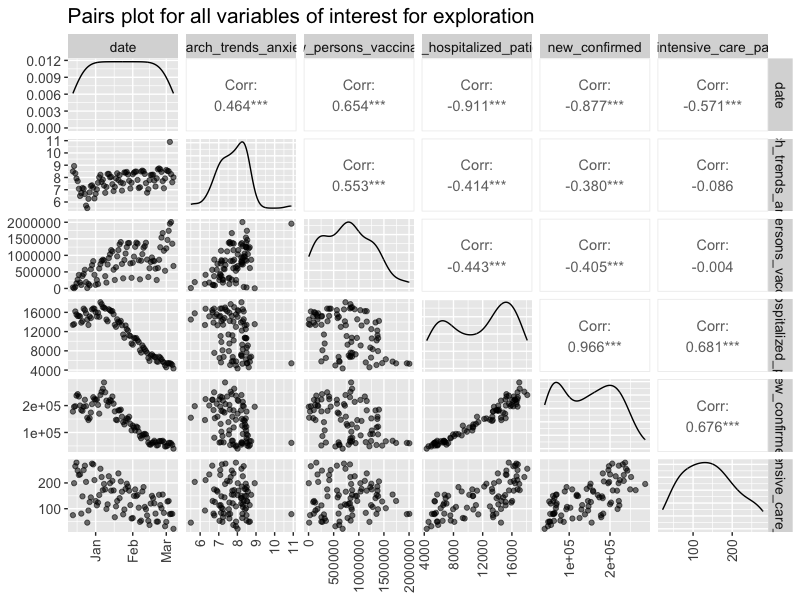

In [37]:
options(repr.plot.width = 16, repr.plot.height = 12) # change plot sizes to an appropiate size

ggpairs(us_selected, aes(alpha = 0.5)) +
    theme(text = element_text(size = 13)) +
    ggtitle("Pairs plot for all variables of interest for exploration") +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))

<h4>Figure 1. Exploratory Analysis of Predictors and their Distribution</h4>

> From this pairwise plot, we observe that:
> 
> `new_persons_vaccinated` seems to have a moderate positive linear correlation with anxiety serach trend.
> 
> `new_hospitalized_patients` seems to have a weak negative linear correlation with anxiety serach trend.
>
> `new_confirmed` seems to have a weak negative linear correlation with anxiety serach trend.
>
> `date` seems to have a weak positive linear correlation with anxiety serach trend.

Warning message:
Removed 5 rows containing missing values or values outside the scale range (`geom_line()`). 


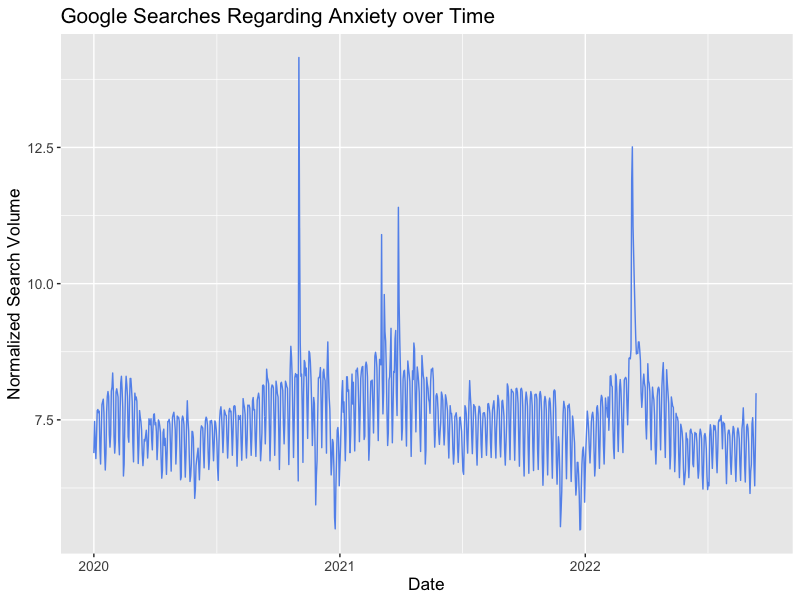

In [38]:
options(repr.plot.width = 14, repr.plot.height = 9) 


anxiety_time_plot <- ggplot(us_covid, aes(y = search_trends_anxiety, x = date)) +
                      geom_line(color = "cornflower blue")+
                      labs(title = "Google Searches Regarding Anxiety over Time",
                           x = "Date",
                           y = "Normalized Search Volume") +
                        theme(text = element_text(size = 13)) 


anxiety_time_plot

<h4>Figure 2: Time Series Plot of the Normalized Google Search Volume for Anxiety on a given date </h4>

> Observations: Anxiety searches seem to be consistent across the COVID-19 pandemic except for 3 peaks around winter of 2020, spring of 2021, and spring of 2022.

<h2>Picking the best features: Backward Selection </h2>

> Train-test split: first sampling 30% for the bwd_select_train group, and then splitting the remaining data (model_data) into a 70% training set and 30% test set based on the date column.

In [39]:
set.seed(310)

# split data into training and testing sets:
bwd_select_train <- sample_n(us_selected, size = nrow(us_selected) * 0.3,
                        replace = FALSE)
model_data <- anti_join(us_selected, 
                        bwd_select_train,
                        by = "date")
covid_train <- sample_n(model_data, size = nrow(model_data) * 0.7,
                        replace = FALSE)
covid_test <- anti_join(model_data, 
                        covid_train,
                        by = "date")


In [40]:
# converts dates into number of days:
covid_train_numeric <- covid_train |> 
                       mutate(date = as.numeric(date))


# backward selection:
covid_backward_sel <- regsubsets(x = search_trends_anxiety ~ new_persons_vaccinated + 
                                                             new_hospitalized_patients +
                                                             new_confirmed +
                                                             new_intensive_care_patients + date,
                                  nvmax = 5,
                                  data = covid_train_numeric,
                                  method = "backward",)
covid_bwd_summary <- summary(covid_backward_sel)


In [41]:
#call only part of the summary table needed to show the model components
as.tibble((covid_bwd_summary[["which"]]))

# A tibble: 5 × 6
  `(Intercept)` new_persons_vaccinated new_hospitalized_pati…¹ new_confirmed new_intensive_care_p…²
  <lgl>         <lgl>                  <lgl>                   <lgl>         <lgl>                 
1 TRUE          TRUE                   FALSE                   FALSE         FALSE                 
2 TRUE          TRUE                   TRUE                    FALSE         FALSE                 
3 TRUE          TRUE                   TRUE                    FALSE         FALSE                 
4 TRUE          TRUE                   TRUE                    FALSE         TRUE                  
5 TRUE          TRUE                   TRUE                    TRUE          TRUE                  
# ℹ abbreviated names: ¹​new_hospitalized_patients, ²​new_intensive_care_patients
# ℹ 1 more variable: date <lgl>

<h4>Table 4: The features being selected during each step of backward model selection </h4>

In [42]:
# summary of each model' performance
covid_bwd_performance <- tibble(n_input_variables = 1:5,
                               RSQ = covid_bwd_summary$rsq,
                               RSS = covid_bwd_summary$rss,
                               ADJ.R2 = covid_bwd_summary$adjr2)
covid_bwd_performance

# A tibble: 5 × 4
  n_input_variables   RSQ   RSS ADJ.R2
              <int> <dbl> <dbl>  <dbl>
1                 1 0.321  16.7  0.304
2                 2 0.329  16.5  0.294
3                 3 0.356  15.9  0.305
4                 4 0.375  15.4  0.308
5                 5 0.375  15.4  0.289

<h4>Table 5: RSQ, RSS, and Adjusted R^2 of each model with the number of features used</h4>

> To select the best-performing features to use to predict Anxiety google searches during the COVID-19 pandemic, we used backward selection to pick the set of features that would produce the best highest adjusted $R^2$ value. Higher $R^2$ value greater predicative ability of the feature variables for the response variable, thereby giving us the model that explained our data the best.
>
> As seen in Table 2, a model with 3 features provides the highest adjusted $R^2$ value at 0.308 based on the validation set. This model contains the variables `new_persons_vaccinated`, `new_hospitalized_patients`, and `date`, which provides some evidence for our hypothesis that higher vaccination rates and greater hospitalization may lead to greater anxiety search trend during COVID-19.

<h2>Creating the final model using selected variables </h2>

In [43]:
# create a mulitple linear regression model with the selected features
final_model <- lm(search_trends_anxiety ~ new_persons_vaccinated + new_hospitalized_patients + date,
                  data = covid_train_numeric)

#create a table with the regression results
tidy(final_model)

# A tibble: 4 × 5
  term                          estimate     std.error statistic p.value
  <chr>                            <dbl>         <dbl>     <dbl>   <dbl>
1 (Intercept)               337.         258.               1.31 0.199  
2 new_persons_vaccinated      0.00000116   0.000000325      3.56 0.00101
3 new_hospitalized_patients  -0.0000911    0.0000637       -1.43 0.161  
4 date                       -0.0176       0.0138          -1.28 0.209  

<h4>Table 6: Coefficients and intercept of the selected linear model </h4>

> Linear formula of our model:
> 
> ***Anxiety search trend =  $1.16 × 10^{-6}$ New vaccination $- 9.11×10^{-5}$ New hospitalization $-0.018$ date $+ 337.11$***
>
> (where date is measured in days.)

<h2>Testing the final model</h2>

In [44]:
# make sure dates are in numeric form as days since 1970-01-01
covid_test_numeric <- covid_test|> 
                      mutate(date = as.numeric(date))
# apply the model to predict test data
final_model_predictions <- predict(final_model, newdata = covid_test_numeric)

# find the RMSE between the model's prediction and the actual values
final_model_RMSPE = rmse(preds = final_model_predictions,
                        actuals = covid_test_numeric$search_trends_anxiety)

# preview RMSE error rate:
final_model_RMSPE

[1] 0.6589689

In [50]:
# preview R-squared:
r_sqr <- summary(final_model)$r.squared
# create dataframe with RMSPE and R-squared
metrics_results<-tibble(RMSPE = final_model_RMSPE, R_square = r_sqr)
metrics_results

# A tibble: 1 × 2
  RMSPE R_square
  <dbl>    <dbl>
1 0.659    0.356

The current model has a root mean square error (RMSE) of 0.659, suggesting a large discrepancy between the actual response value of anxiety search and the predicted response value. The range between the minimum and maximum normalized searches is only about 5.4.

At the same time, this model has a $R^2$ of 0.36, which suggests that around 36% of variance in anxiety Google search trend during the COVID-19 pandemic is explained conjointly by new vaccination, new hospitalization, and progression of time.


## Discussion:

### Summary of Findings

Our results discovered that COVID-19 pandemic-anxiety-related search patterns were weakly influenced by the vaccination rate, hospital rates, and the time elapsed. The vaccination rate increase was strongly correlated with anxiety-related search increases, but growing hospital rates were correlated with decreased anxiety searches. The model's 36% variance explanation suggests the possibility that additional independent variables beyond what was measured within the database may also contribute to a massive amount of this variance.

### Expected vs. Actual Results

The small but positive relationship between vaccination rates and anxiety searches went against our expectations as one would expect higher vaccination rates would reduce anxiety. However, it could be an expression of public concern regarding side effects of vaccinations or the overall impact of vaccination campaigns on society. The negative relationship between hospitalization rates and anxiety searches aligns with the hypothesis that serious COVID-19 complications will generate fewer online searches because of increased stress or disengagement.

### Impact of Findings

These are indicators of the complex interactions between public and mental health interventions during a pandemic. Knowledge of these interactions could allow policymakers to develop improved communication strategies for reducing worry and anxiety in the public.

### Future Questions

- Future research areas might include:
- The role of media coverage in producing anxiety-supportive search trends.
- The impact of other measures of mental health, depression or stress, on searching.



## References:

GoogleCloudPlatform. (2021). *covid-19-open-data* [Source code]. GitHub. Retrieved October 10, 2023, from https://github.com/GoogleCloudPlatform/covid-19-open-data

Murphy, L., Markey, K., O'Donnell, C., Moloney, M., & Doody, O. (2021). The impact of the COVID-19 pandemic and its related restrictions on people with pre-existent mental health conditions: A scoping review. Archives of Psychiatric Nursing, 35(4), 375-394. https://doi.org/10.1016/j.apnu.2021.05.002 

Prati, G., & Mancini, A. D. (2021). The psychological impact of COVID-19 pandemic lockdowns: A review and meta-analysis of longitudinal studies and natural experiments. Psychological Medicine, 51(2), 201-211. https://doi.org/10.1017/S0033291721000015

Neill, R. D., Blair, C., Best, P., McGlinchey, E., & Armour, C. (2023). Media consumption and mental health during COVID-19 lockdown: A UK cross-sectional study across England, Wales, Scotland, and Northern Ireland. Z Gesundh Wiss, 31(3), 435-443. https://doi.org/10.1007/s10389-021-01506-0

Borges do Nascimento, I. J., Pizarro, A. B., Almeida, J. M., Azzopardi-Muscat, N., Gonçalves, M. A., Björklund, M., & Novillo-Ortiz, D. (2022). Infodemics and health misinformation: A systematic review of reviews. Bulletin of the World Health Organization, 100(9), 544-561. https://doi.org/10.2471/BLT.21.287654

